In [1]:
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
path_interim = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/interim/'
path_processed = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/processed/'

In [3]:
caratteristiche = pd.read_excel(path_interim+'caratteristiche.xlsx')
costi = pd.read_excel(path_interim+'costi.xlsx')
efficienza_energetica = pd.read_excel(path_interim+'efficienza_energetica.xlsx')

In [4]:
caratteristiche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   immobile garantito                            3821 non-null   object 
 1   riferimento e Data annuncio                   9065 non-null   object 
 2   contratto                                     9065 non-null   object 
 3   tipologia                                     9065 non-null   object 
 4   superficie                                    9057 non-null   object 
 5   locali                                        9049 non-null   object 
 6   piano                                         8862 non-null   object 
 7   totale piani edificio                         8359 non-null   object 
 8   disponibilità                                 8081 non-null   object 
 9   Tipo proprietà                                8583 non-null   o

In [5]:
costi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   prezzo                                 9065 non-null   object 
 1   informazioni catastali                 5805 non-null   object 
 2   spese condominio                       5248 non-null   object 
 3   stato                                  0 non-null      float64
 4   certificazione energetica              0 non-null      float64
 5   Efficienza energetica                  0 non-null      float64
 6   Tipo vendita                           0 non-null      float64
 7   data vendita                           0 non-null      float64
 8   riscaldamento                          0 non-null      float64
 9   anno di costruzione                    0 non-null      float64
 10  Prestazione energetica del fabbricato  0 non-null      float64
 11  Clim

In [6]:
efficienza_energetica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   anno di costruzione                    6557 non-null   float64
 1   stato                                  8803 non-null   object 
 2   riscaldamento                          8645 non-null   object 
 3   Climatizzazione                        4950 non-null   object 
 4   Indice prest. energetica rinnovabile   287 non-null    object 
 5   Prestazione energetica del fabbricato  594 non-null    object 
 6   Efficienza energetica                  7809 non-null   object 
 7   certificazione energetica              1370 non-null   object 
 8   numero immobili                        0 non-null      float64
 9   offerta minima                         0 non-null      float64
 10  rialzo minimo                          0 non-null      float64
 11  Spes

In [7]:
# Drop NaN columns (based on info above, possible error in scraping)
caratteristiche = caratteristiche.drop(columns=['unità', 'Data di inizio lavori e di consegna prevista', 'Dati catastali'])
costi = costi.iloc[:, :3]
efficienza_energetica = efficienza_energetica.iloc[:, :8]

## 1. Data cleaning

#### Join all three tables and start looking into the data

In [8]:
# Join tables
df = caratteristiche.join(costi).join(efficienza_energetica)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   immobile garantito                     3821 non-null   object 
 1   riferimento e Data annuncio            9065 non-null   object 
 2   contratto                              9065 non-null   object 
 3   tipologia                              9065 non-null   object 
 4   superficie                             9057 non-null   object 
 5   locali                                 9049 non-null   object 
 6   piano                                  8862 non-null   object 
 7   totale piani edificio                  8359 non-null   object 
 8   disponibilità                          8081 non-null   object 
 9   Tipo proprietà                         8583 non-null   object 
 10  altre caratteristiche                  8488 non-null   object 
 11  Post

In [10]:
df.isna().sum()

immobile garantito                       5244
riferimento e Data annuncio                 0
contratto                                   0
tipologia                                   0
superficie                                  8
locali                                     16
piano                                     203
totale piani edificio                     706
disponibilità                             984
Tipo proprietà                            482
altre caratteristiche                     577
Posti Auto                               6791
indirizzo                                   0
zona                                       64
prezzo                                      0
informazioni catastali                   3260
spese condominio                         3817
anno di costruzione                      2508
stato                                     262
riscaldamento                             420
Climatizzazione                          4115
Indice prest. energetica rinnovabi

#### Preliminary cleaning

In [11]:
# Rename columns
df.columns = map(str.capitalize, df.columns)

# Remove rentals
df = df.loc[df['Contratto'] != 'Affitto', :]

# Checking for and removing duplicates
df.duplicated().sum()
df = df.drop_duplicates()

# Not in Firenze
df = df.drop(index=[1279, 4985])

#### Address

In [12]:
df['Indirizzo'] = df['Indirizzo'].str.replace("[",'').str.replace("]",'').str.replace('\'', '')

# Manually impute missing "Zona"
df.loc[df['Indirizzo'] == 'Firenze, via vittorio emanuele orlando', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via borgo la noce', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, via Cigoli 31', 'Zona'] = 'L Isolotto'
df.loc[df['Indirizzo'] == 'Firenze, via impruneta per mezzomonte', 'Zona'] = 'Bellosguardo Galluzzo'
df.loc[df['Indirizzo'] == 'Firenze, via gioberti', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via dei cioli 50', 'Zona'] = 'Settignano Rovezzano'
df.loc[df['Indirizzo'] == 'Firenze, via spinucci 1', 'Zona'] = 'Serpiolle Careggi'
df.loc[df['Indirizzo'] == 'Firenze, "via lungo laffrico 50"', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via lippi', 'Zona'] = 'Legnaia Soffiano'
df.loc[df['Indirizzo'] == 'Firenze, cairoli', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via aretina', 'Zona'] = 'Coverciano Bellariva'
df.loc[df['Indirizzo'] == 'Firenze, via Fra Bartolommeo  40', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, viale don minzoni 1', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, viale don minzoni  1', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, piazza beccaria', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, via san zanobi', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Piazzale Michelangelo', 'Zona'] = 'Michelangelo Porta Romana'
df.loc[df['Indirizzo'] == 'Firenze, Via del Paradiso', 'Zona'] = 'Zona Firenze Sud'
df.loc[df['Indirizzo'] == 'Firenze, via di Canonica', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Via di Canonica', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, Via Frusa', 'Zona'] = 'Campo Di Marte Liberta'
df.loc[df['Indirizzo'] == 'Firenze, Via Vespucci', 'Zona'] = 'Firenze Nord'
df.loc[df['Indirizzo'] == 'Firenze, via baracca  148', 'Zona'] = 'Firenze Nord'
df.loc[df['Indirizzo'] == 'Firenze, via dei Tavolini 1', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, via Pisana 980', 'Zona'] = 'Ugnano Mantignano'
df.loc[df['Indirizzo'] == 'Firenze, VIA SENESE', 'Zona'] = 'Bellosguardo Galluzzo'
df.loc[df['Indirizzo'] == 'Firenze, "piazza dAzeglio"', 'Zona'] = 'Centro'
df.loc[df['Indirizzo'] == 'Firenze, "Piazza dazeglio"', 'Zona'] = 'Centro'

#### Zona

In [13]:
df['Zona'] = df['Zona'].fillna('Non specificato')

df['Zona'] = (df['Zona']
              .str.replace('-', ' ')
              .str.replace('/', '')
              .str.title())
df['Zona'] = df['Zona'].replace({'L Isolotto': 'L\'Isolotto'})

In [14]:
df['Zona'].unique()

array(['Bellosguardo Galluzzo', 'Coverciano Bellariva', 'Firenze Nord',
       'Campo Di Marte Liberta', 'Legnaia Soffiano', 'Centro', 'Oltrarno',
       'Zona Firenze Sud', 'Leopoldo Porta Al Prato', 'Serpiolle Careggi',
       "L'Isolotto", 'Non Specificato', 'Settignano Rovezzano',
       'Zona Bolognese Le Cure', 'Michelangelo Porta Romana',
       'Ugnano Mantignano'], dtype=object)

#### Price

In [15]:
# Missing labels
df.loc[df['Prezzo'] == 'Prezzo su richiesta', :].shape

(289, 25)

In [16]:
# Drop missing labels
df = df.loc[df['Prezzo'] != 'Prezzo su richiesta', :]

In [17]:
df['Prezzo_EUR'] = (df['Prezzo']
                      .str.split('€')
                      .str[1]
                      .str.replace('.', '')
                      .astype('float'))

In [18]:
df['Prezzo_EUR'].isna().sum()

0

#### Area

In [19]:
def extract_area(row):
    try:
        if '\|' in row['Superficie']:
            row['Superficie_m2'] = float(re.search('(\d+\.?\d*)',
                                                   row['Superficie'].split('\|')[1]).group(0).replace('.', ''))
        else:
            row['Superficie_m2'] = float(re.search('(\d+\.?\d*)',
                                                   row['Superficie']).group(0).replace('.', ''))
    except TypeError:
        pass
    
    return row['Superficie_m2']

In [20]:
df['Superficie_m2'] = df['Superficie'].copy()
df['Superficie_m2'] = df.apply(extract_area, axis=1)

In [21]:
# Outlier probably 240
df['Superficie_m2'].max()

240018.0

In [22]:
df.loc[df['Superficie_m2'].idxmax(), :]

Immobile garantito                                                                     NaN
Riferimento e data annuncio                                       EK-63918936 - 08/12/2019
Contratto                                                                          Vendita
Tipologia                                                                     Appartamento
Superficie                                     240.018 m²                 - Vedi dettaglio
Locali                                   5+ (4 camere da letto, 5 altri), 3+ bagni, cuc...
Piano                                                                 da seminterrato a 2°
Totale piani edificio                                                              2 piani
Disponibilità                                                                       Libero
Tipo proprietà                                     Intera proprietà, classe immobile media
Altre caratteristiche                    Fibra ottica\n                \n\n            ...

In [23]:
df.loc[df['Superficie_m2'].idxmax(), 'Superficie_m2'] = 240

#### State

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

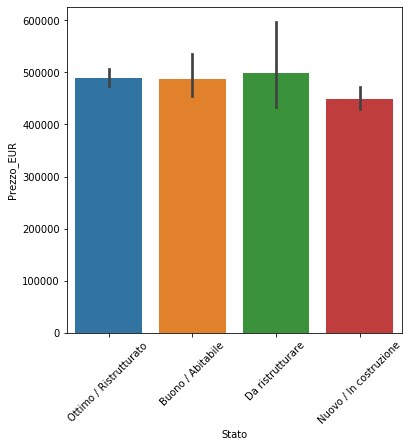

In [24]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Stato'], y=df['Prezzo_EUR'])
plt.xticks(rotation=45)

In [25]:
df['Stato'].value_counts()

Ottimo / Ristrutturato    4529
Buono / Abitabile         2404
Nuovo / In costruzione     897
Da ristrutturare           678
Name: Stato, dtype: int64

In [26]:
# Imputing "Stato" by most frequent as it does not seem to influence price much
df['Stato'] = df['Stato'].fillna(df['Stato'].value_counts().index[0])

#### Contract

In [27]:
# Looking into "Contratto": does it affect price?
gb = df['Prezzo_EUR'].groupby(df['Contratto']).agg('mean')
gb

Contratto
Vendita                         489644.840990
Vendita | Immobile a reddito    466355.491329
Name: Prezzo_EUR, dtype: float64

#### Dropping useless columns

In [28]:
# Drop columns that have almost no entries
# Dropping "Disponibilità" and "Contratto" because it is not relevant information
df = df.drop(columns=['Immobile garantito', 'Indice prest. energetica rinnovabile',
                      'Prestazione energetica del fabbricato', 'Certificazione energetica',
                      'Disponibilità', 'Contratto'])

## 2. Feature engineering

#### Heating

In [29]:
df['Riscaldamento'].isna().sum()

398

In [89]:
df['Riscaldamento'].unique()

array(['Autonomo, a radiatori, alimentato a metano',
       'Centralizzato, a radiatori, alimentato a metano',
       'Centralizzato, a radiatori, alimentato a gas',
       'Autonomo, a radiatori, alimentato a gas',
       'Centralizzato, a radiatori, alimentato a gasolio', 'Autonomo',
       'Centralizzato', 'Centralizzato, a radiatori', nan,
       'Autonomo, ad aria, alimentato a pompa di calore',
       'Autonomo, ad aria, alimentato a gas', 'Autonomo, a stufa',
       'Autonomo, a radiatori, alimentazione elettrica',
       'Autonomo, a radiatori', 'Autonomo, alimentato a gas',
       'Centralizzato, a pavimento, alimentato a fotovoltaico',
       'Centralizzato, a pavimento, alimentato a gas',
       'Centralizzato, a pavimento', 'Centralizzato, alimentato a metano',
       'Autonomo, ad aria',
       'Centralizzato, a pavimento, alimentato a metano',
       'Autonomo, a pavimento, alimentato a gas',
       'Centralizzato, a pavimento, alimentato a pompa di calore',
       'Auton

In [30]:
# Create type of heating feature
df['Tipo_riscaldamento'] = df['Riscaldamento'].str.split(',').str[0]

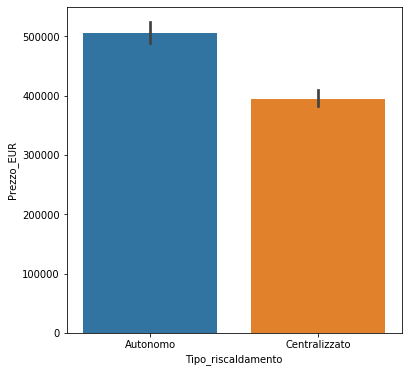

In [31]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Tipo_riscaldamento'], y=df['Prezzo_EUR'])

In [32]:
df['Tipo_riscaldamento'].value_counts()

Autonomo         6516
Centralizzato    1834
Name: Tipo_riscaldamento, dtype: int64

In [33]:
# Filling heating NaNs with centralized because when not specified it is probably centralized
df['Tipo_riscaldamento'] = df['Tipo_riscaldamento'].fillna('Centralizzato')

#### Air conditioning 

In [88]:
df['Climatizzazione'].unique() 

array(['Autonomo, freddo/caldo', 'Predisposizione impianto',
       'Autonomo, freddo', nan, 'Predisposizione impianto, freddo/caldo',
       'Predisposizione impianto, freddo', 'Autonomo',
       'Centralizzato, freddo/caldo', 'Centralizzato, freddo',
       'Autonomo, caldo', 'Centralizzato'], dtype=object)

#### Listing date

In [34]:
df['Riferimento e data annuncio'].head()

0       A0049 - 05/10/2020
1      alv275 - 05/10/2020
2    Novoli B - 05/10/2020
3    Novoli A - 05/10/2020
4     MAZZ328 - 05/10/2020
Name: Riferimento e data annuncio, dtype: object

In [35]:
df['Data_annuncio'] = (df['Riferimento e data annuncio']
                       .str.split('-')
                       .str[-1]
                       .str.strip()
                       .astype('datetime64[D]'))

#### Floor

In [36]:
df['Piano'].value_counts()

1° piano                                                  1101
Piano terra                                                998
1° piano, con ascensore                                    673
2° piano                                                   638
3° piano                                                   493
                                                          ... 
da 1° a 2°, Ultimo, con accesso disabili                     1
7°, con ascensore, con accesso disabili                      1
da seminterrato a piano rialzato, con accesso disabili       1
Interrato (-2), con ascensore                                1
9°, con ascensore, con accesso disabili                      1
Name: Piano, Length: 197, dtype: int64

In [37]:
# Create elevator feature
mask = df['Piano'].str.match(r'(.*ascensore.*)')

df['Ascensore'] = mask.astype('float')
df['Ascensore'] = df['Ascensore'].fillna(df['Ascensore'].value_counts().index[0])

In [38]:
df.loc[df['Piano'].isna(), :]

,Riferimento e data annuncio,Tipologia,Superficie,Locali,Piano,Totale piani edificio,Tipo proprietà,Altre caratteristiche,Posti auto,Indirizzo,Zona,Prezzo,Informazioni catastali,Spese condominio,Anno di costruzione,Stato,Riscaldamento,Climatizzazione,Efficienza energetica,Prezzo_EUR,Superficie_m2,Tipo_riscaldamento,Data_annuncio,Ascensore
80,RIF.1/0315 - 02/10/2020,Loft,60 m²,"2 (1 camera da letto, 1 altro), 2 bagni, cucin...",NaN,NaN,NaN,NaN,NaN,Firenze,Non Specificato,€ 260.000,NaN,NaN,NaN,Ottimo / Ristrutturato,Autonomo,NaN,"F 236,00 kWh/m² anno",260000.0,60.0,Autonomo,2020-02-10,0.0
81,RIF.1/0284 - 02/10/2020,Appartamento,90 m²,"4 (2 camere da letto, 2 altri), 1 bagno, cucin...",NaN,NaN,NaN,NaN,NaN,Firenze,Non Specificato,€ 235.000,NaN,NaN,NaN,Ottimo / Ristrutturato,Autonomo,NaN,G,235000.0,90.0,Autonomo,2020-02-10,0.0
321,RAterramasso. - 02/10/2020,Terratetto unifamiliare,250 m²,"5+ (3 camere da letto, 7 altri), 3 bagni, cuci...",NaN,NaN,Classe immobile signorile,Terrazza\n \n\n ...,NaN,"Firenze, Bolognese",Zona Bolognese Le Cure,€ 1.095.000,NaN,NaN,NaN,Da ristrutturare,Autonomo,NaN,G,1095000.0,250.0,Autonomo,2020-02-10,0.0
329,RAchiantigiana - 02/10/2020,Rustico,250 m²,5 locali,NaN,NaN,NaN,NaN,NaN,"Firenze, Chiantigiana - Ponte a Ema",Zona Firenze Sud,€ 950.000,NaN,NaN,NaN,Buono / Abitabile,NaN,NaN,G,950000.0,250.0,Centralizzato,2020-02-10,0.0
419,ITF235 - 29/09/2020,Appartamento,70 m²,"4 (2 camere da letto, 2 altri), 1 bagno, cucin...",NaN,3 piani,NaN,NaN,NaN,"Firenze, San Marcellino",Zona Firenze Sud,€ 250.000,NaN,€ 50/mese,NaN,Buono / Abitabile,Centralizzato,NaN,"G 237,90 kWh/m² anno",250000.0,70.0,Centralizzato,2020-09-29,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8978,8494 - 05/03/2018,Appartamento,110 m²,"5 (4 camere da letto, 1 altro), 2 bagni, cucin...",NaN,3 piani,Intera proprietà,Giardino comune,NaN,"Firenze, Campo di Marte, VIALE PASQUALE PAOLI",Campo Di Marte Liberta,€ 650.000,NaN,NaN,NaN,Nuovo / In costruzione,Autonomo,"Autonomo, freddo","A 1,00 kWh/m² anno",650000.0,110.0,Autonomo,2018-05-03,0.0
8988,Marignolle Medicea (1493350) - 08/09/2016,Appartamento,200 m²,"4 (1 camera da letto, 3 altri), 2 bagni, cucin...",NaN,NaN,"Intera proprietà, immobile di lusso",Giardino comune,NaN,"Firenze, Marignolle - Bellosguardo",Bellosguardo Galluzzo,€ 1.700.000,NaN,€ 200/mese,NaN,Ottimo / Ristrutturato,"Autonomo, a radiatori","Autonomo, freddo","G 175,00 kWh/m² anno",1700000.0,200.0,Autonomo,2016-08-09,0.0
9011,San Domenico (1493368) - 24/08/2016,Villa unifamiliare,"600 m², terreno di proprietà 19.000 m²","5+ (6 camere da letto, 2 altri), 3 bagni, cuci...",NaN,NaN,Classe immobile signorile,Caminetto\n \n\n ...,2 all'esterno,Firenze,Non Specificato,€ 5.000.000,NaN,NaN,NaN,Ottimo / Ristrutturato,"Autonomo, a radiatori",NaN,"G 175,00 kWh/m² anno",5000000.0,600.0,Autonomo,2016-08-24,0.0
9050,RIF.1/0100 - 23/02/2015,Appartamento,"450 m², terreno di proprietà 200 m²","5+ (4 camere da letto, 3 altri), 3+ bagni, cuc...",NaN,NaN,"Intera proprietà, classe immobile signorile",Cancello elettrico\n \n\n ...,"1 in garage/box, 5 all'esterno","Firenze, Mazzini - Oberdan, VIALE MAZZINI",Campo Di Marte Liberta,€ 1.700.000,NaN,NaN,NaN,Ottimo / Ristrutturato,Centralizzato,NaN,"G 129,00 kWh/m² anno",1700000.0,450.0,Centralizzato,2015-02-23,0.0


In [39]:
# Create access for disabled people feature
mask = df['Piano'].str.match(r'(.*accesso disabili.*)')

df['Accesso_disabili'] = mask.astype('float')
df['Accesso_disabili'] = df['Accesso_disabili'].fillna(df['Accesso_disabili'].value_counts().index[0])

df['Accesso_disabili'].value_counts()

0.0    7402
1.0    1346
Name: Accesso_disabili, dtype: int64

In [40]:
# Create multiple floors feature
mask = df['Piano'].str.match(r'(.*da.*|.*più livelli.*)+')

df['Piu_livelli'] = mask.astype('float')
df['Piu_livelli'] = df['Piu_livelli'].fillna(df['Piu_livelli'].value_counts().index[0])

df['Piu_livelli'].value_counts()

0.0    8170
1.0     578
Name: Piu_livelli, dtype: int64

In [41]:
df['Totale_piani_edificio'] = (df['Totale piani edificio']
                               .str.split(' ')
                               .str[0]
                               .astype('float'))

In [42]:
# Based on missing values and assuming this is not an important feature, we will surely drop it later
df.loc[df['Totale_piani_edificio'].isna(), :]

,Riferimento e data annuncio,Tipologia,Superficie,Locali,Piano,Totale piani edificio,Tipo proprietà,Altre caratteristiche,Posti auto,Indirizzo,Zona,Prezzo,Informazioni catastali,Spese condominio,Anno di costruzione,Stato,Riscaldamento,Climatizzazione,Efficienza energetica,Prezzo_EUR,Superficie_m2,Tipo_riscaldamento,Data_annuncio,Ascensore,Accesso_disabili,Piu_livelli,Totale_piani_edificio
10,EK-83082787 - 05/10/2020,Appartamento,60 m²,"3 (2 camere da letto, 1 altro), 1 bagno, cucin...",1° piano,NaN,Intera proprietà,NaN,NaN,"Firenze, Via Pisana, Legnaia - San Quirico - M...",Legnaia Soffiano,€ 183.000,NaN,€ 30/mese,NaN,Ottimo / Ristrutturato,Autonomo,NaN,D,183000.0,60.0,Autonomo,2020-05-10,0.0,0.0,0.0,NaN
46,EK-83048755 - 05/10/2020,Appartamento,85 m²,"3 (2 camere da letto, 1 altro), 2 bagni","4° piano, con ascensore",NaN,Intera proprietà,Cantina,NaN,"Firenze, Viale Spartaco Lavagnini, 24, Libertà...",Campo Di Marte Liberta,€ 350.000,NaN,€ 150/mese,NaN,Ottimo / Ristrutturato,Centralizzato,NaN,NaN,350000.0,85.0,Centralizzato,2020-05-10,1.0,0.0,0.0,NaN
50,EK-83075555 - 05/10/2020,Appartamento,120 m²,"4 (3 camere da letto, 1 altro), 2 bagni, cucin...","1° piano, con ascensore",NaN,Intera proprietà,Cantina\n \n\n ...,1 all'esterno,"Firenze, Via Gran Bretagna, Europa, Via Gran B...",Zona Firenze Sud,€ 397.000,NaN,€ 120/mese,NaN,Buono / Abitabile,Autonomo,NaN,G,397000.0,120.0,Autonomo,2020-05-10,1.0,0.0,0.0,NaN
59,183933 - 16/09/2020,Appartamento,82 m²,"3 locali, 1 bagno",1° piano,NaN,Intera proprietà,NaN,NaN,"Firenze, ""via dellantella"", Chiantigiana - Pon...",Zona Firenze Sud,€ 265.000,NaN,NaN,NaN,Buono / Abitabile,NaN,NaN,NaN,265000.0,82.0,Centralizzato,2020-09-16,0.0,0.0,0.0,NaN
60,EK-83084011 - 05/10/2020,Villa a schiera,200 m²,"5+ (5 camere da letto, 4 altri), 3 bagni, cuci...",Piano terra,NaN,Intera proprietà,Giardino privato,1 in garage/box,"Firenze, Via Giuseppe Galliano, Porta al Prato...",Leopoldo Porta Al Prato,€ 650.000,NaN,NaN,NaN,Buono / Abitabile,Autonomo,NaN,NaN,650000.0,200.0,Autonomo,2020-05-10,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9041,A1905 - 18/09/2018,Appartamento,200 m²,NaN,1° piano,NaN,NaN,NaN,NaN,"Firenze, Borgo Pinti, ""DAzeglio""",Centro,€ 1.200.000,NaN,NaN,1900.0,Ottimo / Ristrutturato,NaN,NaN,G ≥ 175 kWh/m² anno,1200000.0,200.0,Centralizzato,2018-09-18,0.0,0.0,0.0,NaN
9043,EK-46843251 - 11/02/2020,Appartamento,220 m²,"5+ (5 camere da letto, 1 altro), 3+ bagni, cuc...","Piano rialzato, con ascensore",NaN,"Intera proprietà, classe immobile signorile",Caminetto\n \n\n ...,NaN,"Firenze, Via Lorenzo Il Magnifico, Libertà - S...",Campo Di Marte Liberta,€ 690.000,NaN,NaN,NaN,Ottimo / Ristrutturato,Autonomo,NaN,E ≥ 175 kWh/m² anno,690000.0,220.0,Autonomo,2020-11-02,1.0,0.0,0.0,NaN
9050,RIF.1/0100 - 23/02/2015,Appartamento,"450 m², terreno di proprietà 200 m²","5+ (4 camere da letto, 3 altri), 3+ bagni, cuc...",NaN,NaN,"Intera proprietà, classe immobile signorile",Cancello elettrico\n \n\n ...,"1 in garage/box, 5 all'esterno","Firenze, Mazzini - Oberdan, VIALE MAZZINI",Campo Di Marte Liberta,€ 1.700.000,NaN,NaN,NaN,Ottimo / Ristrutturato,Centralizzato,NaN,"G 129,00 kWh/m² anno",1700000.0,450.0,Centralizzato,2015-02-23,0.0,0.0,0.0,NaN
9057,Villa Iris (1493551) - 24/08/2016,Villa unifamiliare,340 m²,"5 locali, 3+ bagni, cucina abitabile",NaN,NaN,NaN,Terrazza\n \n\n ...,1 all'esterno,"Firenze, Bolognese",Zona Bolognese Le Cure,€ 2.500.000,NaN,NaN,NaN,Buono / Abitabile,"Autonomo, a radiatori",NaN,"G 160,00 kWh/m² anno",2500000.0,340.0,Autonomo,2016-08-24,0.0,0.0,0.0,NaN


#### Other characteristics

In [43]:
df['Altre caratteristiche'].unique()

array(['Fibra ottica\n                \n\n                    VideoCitofono\n                \n\n                    Porta blindata\n                \n\n                    Impianto tv singolo\n                \n\n                    Parzialmente Arredato\n                \n\n                    Infissi esterni in vetro / legno\n                \n\n                    Esposizione doppia',
       'Fibra ottica\n                \n\n                    Porta blindata\n                \n\n                    Balcone\n                \n\n                    Impianto tv centralizzato\n                \n\n                    Infissi esterni in doppio vetro / PVC\n                \n\n                    Esposizione doppia',
       'Porta blindata\n                \n\n                    Esposizione esterna\n                \n\n                    Terrazza\n                \n\n                    Impianto tv singolo\n                \n\n                    Infissi esterni in doppio vetro / PVC'

In [44]:
def string_parser(row):
    try:
        string_list = row['Altre caratteristiche'].split('\n')
        row['Altre_caratteristiche'] = [string.strip() for string in string_list if string.strip() != '']
    
    except AttributeError:
        row['Altre_caratteristiche'] = []
    
    return row['Altre_caratteristiche']

In [45]:
df['Altre_caratteristiche'] = df['Altre caratteristiche'].copy()
df['Altre_caratteristiche'] = df.apply(string_parser, axis=1)

In [46]:
mask = df['Altre_caratteristiche'].apply(lambda x: x == [])
df.loc[mask, 'Altre caratteristiche'].isna().sum()

558

In [47]:
# Determine all characteristics
def unique(df):
    unique_list = []

    for idx, series in df.iterrows():
        for characteristic in series.loc['Altre_caratteristiche']:
            if characteristic not in unique_list:
                unique_list.append(characteristic)
        else:
            continue
   
    return unique_list

In [48]:
unique_list = unique(df)
unique_list

['Fibra ottica',
 'VideoCitofono',
 'Porta blindata',
 'Impianto tv singolo',
 'Parzialmente Arredato',
 'Infissi esterni in vetro / legno',
 'Esposizione doppia',
 'Balcone',
 'Impianto tv centralizzato',
 'Infissi esterni in doppio vetro / PVC',
 'Esposizione esterna',
 'Terrazza',
 'Cancello elettrico',
 'Cantina',
 'Giardino privato',
 'Caminetto',
 'Portiere intera giornata',
 'Infissi esterni in doppio vetro / legno',
 'Armadio a muro',
 'Impianto di allarme',
 'Mansarda',
 'Infissi esterni in doppio vetro / metallo',
 'Solo Cucina Arredata',
 'Esposizione interna',
 'Infissi esterni in vetro / PVC',
 'Giardino comune',
 'Taverna',
 'Impianto tv con parabola satellitare',
 'Arredato',
 'Infissi esterni in triplo vetro / PVC',
 'Infissi esterni in triplo vetro / legno',
 'Infissi esterni in vetro / metallo',
 'Portiere mezza giornata',
 'Cablato',
 'Idromassaggio',
 'Reception',
 'Piscina',
 'Infissi esterni in triplo vetro / metallo']

In [49]:
# Create one-hot encoded feature for each characteristic
for characteristic in unique_list:
    mask = df['Altre_caratteristiche'].apply(lambda x: characteristic in x)
    df[characteristic] = mask.astype('float')

In [50]:
df.head()

,Riferimento e data annuncio,Tipologia,Superficie,Locali,Piano,Totale piani edificio,Tipo proprietà,Altre caratteristiche,Posti auto,Indirizzo,Zona,Prezzo,Informazioni catastali,Spese condominio,Anno di costruzione,Stato,Riscaldamento,Climatizzazione,Efficienza energetica,Prezzo_EUR,Superficie_m2,Tipo_riscaldamento,Data_annuncio,Ascensore,Accesso_disabili,Piu_livelli,Totale_piani_edificio,Altre_caratteristiche,Fibra ottica,VideoCitofono,Porta blindata,Impianto tv singolo,Parzialmente Arredato,Infissi esterni in vetro / legno,Esposizione doppia,Balcone,Impianto tv centralizzato,Infissi esterni in doppio vetro / PVC,Esposizione esterna,Terrazza,Cancello elettrico,Cantina,Giardino privato,Caminetto,Portiere intera giornata,Infissi esterni in doppio vetro / legno,Armadio a muro,Impianto di allarme,Mansarda,Infissi esterni in doppio vetro / metallo,Solo Cucina Arredata,Esposizione interna,Infissi esterni in vetro / PVC,Giardino comune,Taverna,Impianto tv con parabola satellitare,Arredato,Infissi esterni in triplo vetro / PVC,Infissi esterni in triplo vetro / legno,Infissi esterni in vetro / metallo,Portiere mezza giornata,Cablato,Idromassaggio,Reception,Piscina,Infissi esterni in triplo vetro / metallo
0,A0049 - 05/10/2020,Appartamento,58 m²,"2 (1 camera da letto, 1 altro), 1 bagno, cucin...",1° piano,2 piani,"Intera proprietà, classe immobile media",Fibra ottica\n \n\n ...,NaN,"Firenze, Via del Podestà, Galluzzo",Bellosguardo Galluzzo,€ 260.000,"Classe A/4, rendita € 278",NaN,1900.0,Ottimo / Ristrutturato,"Autonomo, a radiatori, alimentato a metano","Autonomo, freddo/caldo","F 236,08 kWh/m² anno",260000.0,58.0,Autonomo,2020-05-10,0.0,0.0,0.0,2.0,"[Fibra ottica, VideoCitofono, Porta blindata, ...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,alv275 - 05/10/2020,Appartamento,65 m²,"3 (2 camere da letto, 1 altro), 1 bagno, cucin...","3° piano, con ascensore",4 piani,"Intera proprietà, classe immobile signorile",Fibra ottica\n \n\n ...,NaN,"Firenze, Viale Giovanni Verga, Coverciano, Via...",Coverciano Bellariva,€ 275.000,"Classe A/2, rendita € 888",€ 90/mese,1960.0,Ottimo / Ristrutturato,"Centralizzato, a radiatori, alimentato a metano",Predisposizione impianto,"F ≥ 3,51 kWh/m² anno",275000.0,65.0,Centralizzato,2020-05-10,1.0,0.0,0.0,4.0,"[Fibra ottica, Porta blindata, Balcone, Impian...",1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Novoli B - 05/10/2020,Appartamento,54 m²,"2 (1 camera da letto, 1 altro), 1 bagno, cucin...","5° piano, con ascensore",7 piani,"Intera proprietà, classe immobile signorile",Porta blindata\n \n\n ...,NaN,"Firenze, Novoli, Via di Novoli, Via di Novoli, 5",Firenze Nord,€ 195.000,"Classe A/2, rendita € 150",€ 50/mese,1980.0,Ottimo / Ristrutturato,"Centralizzato, a radiatori, alimentato a gas",Predisposizione impianto,G ≥ 175 kWh/m² anno,195000.0,54.0,Centralizzato,2020-05-10,1.0,0.0,0.0,7.0,"[Porta blindata, Esposizione esterna, Terrazza...",0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Novoli A - 05/10/2020,Appartamento,56 m²,"2 (1 camera da letto, 1 altro), 1 bagno, cucin...","5° piano, con ascensore",7 piani,"Intera proprietà, classe immobile signorile",Porta blindata\n \n\n ...,NaN,"Firenze, Novoli, Via di Novoli, Via di Novoli, 5",Firenze Nord,€ 195.000,"Classe A/2, rendita € 150",€ 50/mese,1980.0,Ottimo / Ristrutturato,"Centralizzato, a radiatori, alimentato a gas",Predisposizione impianto,G ≥ 175 kWh/m² anno,195000.0,56.0,Centralizzato,2020-05-10,1.0,0.0,0.0,7.0,"[Porta blindata, Esposizione esterna, Terrazza...",0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MAZZ328 - 05/10/202

#### Car parking

In [51]:
df['Posti auto'].unique()

array([nan, "1 all'esterno", "2 all'esterno", '1 in garage/box',
       "6 all'esterno", "3 all'esterno", '2 in garage/box',
       "1 in garage/box, 1 all'esterno", "4 all'esterno", "5 all'esterno",
       "2 in garage/box, 2 all'esterno", "2 in garage/box, 8 all'esterno",
       "1 in garage/box, 2 all'esterno", "2 in garage/box, 1 all'esterno",
       "10 all'esterno", "1 in garage/box, 3 all'esterno",
       "176 all'esterno", "2 in garage/box, 10 all'esterno",
       "2 in garage/box, 5 all'esterno", "2 in garage/box, 6 all'esterno",
       "9 all'esterno", "1 in garage/box, 4 all'esterno",
       "1 in garage/box, 6 all'esterno", "7 all'esterno",
       "1 in garage/box, 5 all'esterno", "20 all'esterno",
       "2 in garage/box, 20 all'esterno",
       "2 in garage/box, 3 all'esterno",
       "1 in garage/box, 14 all'esterno",
       "2 in garage/box, 4 all'esterno", "1 in garage/box, 7 all'esterno",
       "8 all'esterno", "2 in garage/box, 7 all'esterno",
       "2 in garage/bo

In [52]:
# Consider NaNs as no parkings
df['Posti auto'].isna().sum()

6598

In [53]:
# Garage car parking
df['Posti_garage'] = (df['Posti auto']
                      .str.findall(r'\d? .* garage\/box')
                      .str[0]
                      .str.split(' ')
                      .str[0])

df.loc[df['Posti_garage'].isna(), 'Posti_garage'] = 0
df['Posti_garage'] = df['Posti_garage'].astype('float')

df['Posti_garage'].value_counts()

0.0    7862
1.0     671
2.0     215
Name: Posti_garage, dtype: int64

In [54]:
# External car parking
df['Posti_esterni'] = (df['Posti auto']
                      .str.findall(r'\d?\d? .*esterno')
                      .str[0]
                      .str.split(' ')
                      .str[0])

df.loc[df['Posti_esterni'].isna(), 'Posti_esterni'] = 0
df['Posti_esterni'] = df['Posti_esterni'].astype('float')

df['Posti_esterni'].value_counts()

0.0     7082
1.0     1208
2.0      350
3.0       43
4.0       27
5.0       11
10.0       9
6.0        7
8.0        4
20.0       3
7.0        2
76.0       1
9.0        1
Name: Posti_esterni, dtype: int64

#### Number of rooms and toilets

In [55]:
# Create number of rooms feature
pat = r'\(.*\)'
repl = lambda m: m.group(0).replace(',', ';')

df['Locali'] = df['Locali'].str.replace(pat, repl)

In [56]:
# Toilets
df['Num_bagni'] = (df['Locali']
                   .str.findall(r'(\d\+? bagn\w)')
                   .str[0]
                   .str.split(' ')
                   .str[0])

df.loc[df['Num_bagni'].isna(), 'Num_bagni'] = 0
df.loc[df['Num_bagni'] == '3+', 'Num_bagni'] = 4 # Set 3+ toilets to 4
df['Num_bagni'] = df['Num_bagni'].astype('float')

df['Num_bagni'].value_counts()

1.0    4428
2.0    2992
3.0     780
4.0     442
0.0     106
Name: Num_bagni, dtype: int64

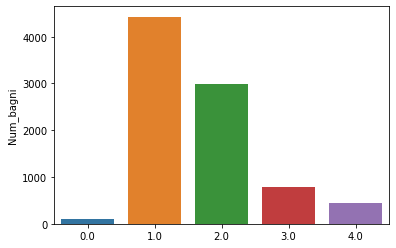

In [57]:
sns.barplot(x=df['Num_bagni'].value_counts().index, y=df['Num_bagni'].value_counts())

In [58]:
df.loc[df['Num_bagni'] == 0, 'Superficie_m2']

99      120.0
119     500.0
329     250.0
409      95.0
441     200.0
        ...  
8657    350.0
8755     58.0
8773     21.0
8960    172.0
9041    200.0
Name: Superficie_m2, Length: 106, dtype: float64

In [59]:
# Create area bins for imputing
df['Superficie_Bins'] = pd.cut(df['Superficie_m2'].dropna(), bins=[0, 60, 80, 100, 120, 160, 200, 20000])

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

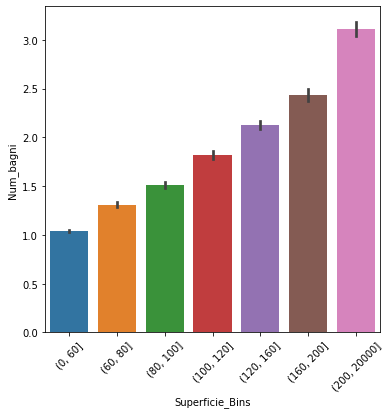

In [60]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Num_bagni'])
plt.xticks(rotation=45)

In [61]:
df.groupby(['Superficie_Bins'])['Num_bagni'].agg(lambda x:x.value_counts().index[0])

Superficie_Bins
(0, 60]         1.0
(60, 80]        1.0
(80, 100]       1.0
(100, 120]      2.0
(120, 160]      2.0
(160, 200]      2.0
(200, 20000]    4.0
Name: Num_bagni, dtype: float64

In [62]:
# Imputing number of toilets based on area bins
for area in df['Superficie_Bins'].unique():
    mask = df['Superficie_Bins'] == area
    df.loc[mask & (df['Num_bagni'] == 0), 'Num_bagni'] = df.loc[mask, 'Num_bagni'].mode().values

In [63]:
df['Num_altri'] = (df['Locali']
                   .str.findall(r'(\d?\d\+? altr\w)')
                   .str[0]
                   .str.split(' ')
                   .str[0]
                   .astype('float'))

df.loc[df['Num_altri'].isna(), 'Num_altri'] = 0 # Set NaNs to 0 to be able to sum

In [64]:
df['Num_camere_letto'] = (df['Locali']
                          .str.findall(r'(\d?\d\+? camer\w da letto)')
                          .str[0]
                          .str.split(' ')
                          .str[0]
                          .astype('float'))

df.loc[df['Num_camere_letto'].isna(), 'Num_camere_letto'] = 0 # Set NaNs to 0 to be able to sum

In [65]:
df['Num_locali'] = (df['Locali']
                    .str.findall(r'(\d?\d\+? local\w)')
                    .str[0]
                    .str.split(' ')
                    .str[0]
                    .astype('float'))

df.loc[df['Num_locali'].isna(), 'Num_locali'] = 0 # Set NaNs to 0 to be able to sum

In [66]:
df['Num_tot_locali'] = df['Num_locali'] + df['Num_camere_letto'] + df['Num_altri']

In [67]:
df.loc[df['Locali'].isna(), :].shape

(13, 74)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

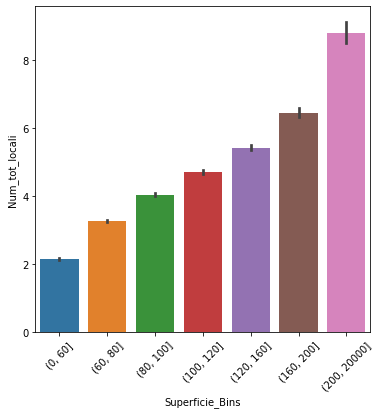

In [68]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Num_tot_locali'])
plt.xticks(rotation=45)

In [69]:
# Imputing number of rooms based on area bins
for area in df['Superficie_Bins'].unique():
    mask = df['Superficie_Bins'] == area
    df.loc[mask & (df['Num_tot_locali'] == 0), 'Num_tot_locali'] = df.loc[mask, 'Num_tot_locali'].mode().values

In [70]:
df.loc[df['Num_tot_locali'].isna(), :].shape

(0, 74)

#### Imputing area

In [71]:
df.loc[df['Superficie_m2'].isna(), :]

,Riferimento e data annuncio,Tipologia,Superficie,Locali,Piano,Totale piani edificio,Tipo proprietà,Altre caratteristiche,Posti auto,Indirizzo,Zona,Prezzo,Informazioni catastali,Spese condominio,Anno di costruzione,Stato,Riscaldamento,Climatizzazione,Efficienza energetica,Prezzo_EUR,Superficie_m2,Tipo_riscaldamento,Data_annuncio,Ascensore,Accesso_disabili,Piu_livelli,Totale_piani_edificio,Altre_caratteristiche,Fibra ottica,VideoCitofono,Porta blindata,Impianto tv singolo,Parzialmente Arredato,Infissi esterni in vetro / legno,Esposizione doppia,Balcone,Impianto tv centralizzato,Infissi esterni in doppio vetro / PVC,Esposizione esterna,Terrazza,Cancello elettrico,Cantina,Giardino privato,Caminetto,Portiere intera giornata,Infissi esterni in doppio vetro / legno,Armadio a muro,Impianto di allarme,Mansarda,Infissi esterni in doppio vetro / metallo,Solo Cucina Arredata,Esposizione interna,Infissi esterni in vetro / PVC,Giardino comune,Taverna,Impianto tv con parabola satellitare,Arredato,Infissi esterni in triplo vetro / PVC,Infissi esterni in triplo vetro / legno,Infissi esterni in vetro / metallo,Portiere mezza giornata,Cablato,Idromassaggio,Reception,Piscina,Infissi esterni in triplo vetro / metallo,Posti_garage,Posti_esterni,Num_bagni,Superficie_Bins,Num_altri,Num_camere_letto,Num_locali,Num_tot_locali
5541,VE345CATFA/12 - 28/09/2020,Appartamento,NaN,"5+ (3 camere da letto; 3 altri), 3 bagni, cuci...",Su più livelli,2 piani,NaN,Terrazza\n \n\n ...,1 all'esterno,"Firenze, Campo di Marte, VIA CARNESECCHI",Campo Di Marte Liberta,€ 495.000,NaN,NaN,1600.0,Nuovo / In costruzione,"Autonomo, a radiatori",NaN,"G 175,00 kWh/m² anno",495000.0,NaN,Autonomo,2020-09-28,0.0,0.0,1.0,2.0,"[Terrazza, Infissi esterni in vetro / legno]",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,NaN,3.0,3.0,0.0,6.0
5543,VE345CATFA/7 - 28/09/2020,Appartamento,NaN,"5+ (2 camere da letto; 4 altri), 2 bagni, cuci...",Su più livelli,2 piani,NaN,Terrazza\n \n\n ...,1 all'esterno,"Firenze, Campo di Marte, VIA CARNESECCHI",Campo Di Marte Liberta,€ 695.000,NaN,NaN,1600.0,Nuovo / In costruzione,"Autonomo, a radiatori",NaN,"G 175,00 kWh/m² anno",695000.0,NaN,Autonomo,2020-09-28,0.0,0.0,1.0,2.0,"[Terrazza, Infissi esterni in vetro / legno]",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,NaN,4.0,2.0,0.0,6.0
5544,VE345CATFA/9 - 28/09/2020,Appartamento,NaN,"4 (2 camere da letto; 2 altri), 3 bagni, cucin...",1° piano,2 piani,NaN,Balcone,NaN,"Firenze, Campo di Marte, VIA CARNESECCHI",Campo Di Marte Liberta,€ 565.000,NaN,NaN,1600.0,Nuovo / In costruzione,NaN,NaN,"G 175,00 kWh/m² anno",565000.0,NaN,Centralizzato,2020-09-28,0.0,0.0,0.0,2.0,[Balcone],0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN,2.0,2.0,0.0,4.0
5850,RIF.4062 - 21/04/2020,Appartamento,NaN,"5 locali, 2 bagni, cucina abitabile",NaN,NaN,"Intera proprietà, immobile di lusso",Idromassaggio\n \n\n ...,NaN,"Firenze, Salviatino - San Domenico",Zona Bolognese Le Cure,€ 1.560.000,NaN,€ 1/mese,1500.0,Ottimo / Ristrutturato,"Autonomo, a radiatori, alimentato a gas","Autonomo, freddo","G 176,00 kWh/m² anno",1560000.0,NaN,Autonomo,2020-04-21,0.0,0.0,0.0,NaN,"[Idromassaggio, Cancello elettrico, Caminetto,...",0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,5.0,5.0
5879,RIF.1542 - 29/07/2020,Villa unifamiliare,NaN,"5+ (3 camere da letto; 5 altri), 3+ bagni, cuc...","Piano terra, con ascensore",1 piano,"Intera proprietà, immobile di lusso",Idromassaggio\n \n\n ...,NaN,"Firenze, Bolognese",Zona Bolognese Le Cure,€ 1.700.000,"Classe A/7, rendita € 1",€ 1/mese

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

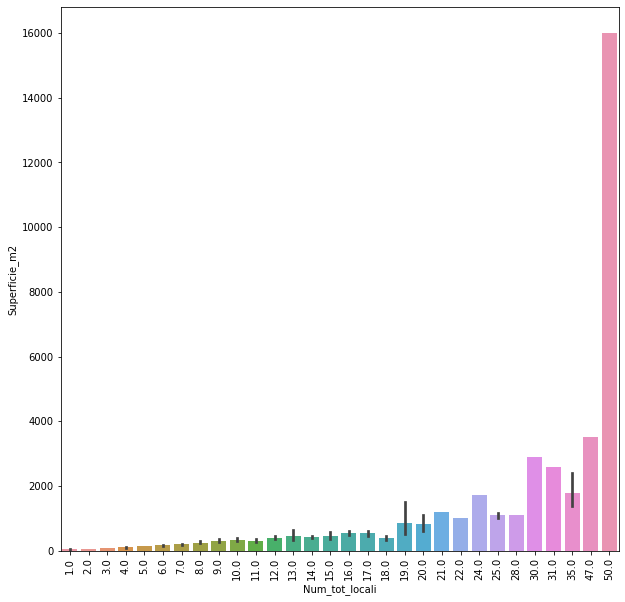

In [72]:
fig = plt.figure(figsize=(10, 10))
sns.barplot(x=df['Num_tot_locali'], y=df['Superficie_m2'])
plt.xticks(rotation=90)

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <a list of 11 Text xticklabel objects>)

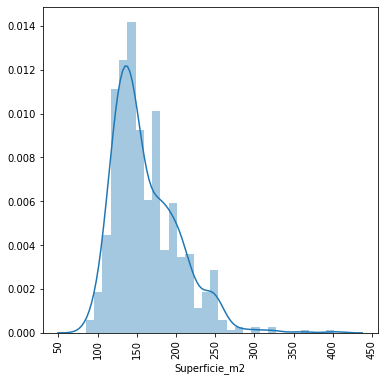

In [73]:
# Distribution of area based on number of rooms
fig = plt.figure(figsize=(6, 6))
sns.distplot(df.loc[df['Num_tot_locali'] == 6, 'Superficie_m2'], bins=30)
plt.xticks(rotation=90)

In [74]:
# Imputing area based on total number of rooms
for n_rooms in df['Num_tot_locali'].unique():
    mask = df['Num_tot_locali'] == n_rooms
    df.loc[mask & (df['Superficie_m2'].isna()), 'Superficie_m2'] = df.loc[mask, 'Superficie_m2'].mean()

In [75]:
# Recreate area bins for imputing
df['Superficie_Bins'] = pd.cut(df['Superficie_m2'], bins=[0, 60, 80, 100, 120, 160, 200, 20000])

#### Year of construction

In [76]:
df.loc[df['Anno di costruzione'].isna(), 'Stato'].value_counts()

Ottimo / Ristrutturato    1502
Buono / Abitabile          558
Nuovo / In costruzione     195
Da ristrutturare           145
Name: Stato, dtype: int64

In [77]:
df['Anno di costruzione'].isna().sum()

2400

#### Price per m2

In [78]:
# Create a price/m2 feature
df['Prezzo_per_m2'] = df['Prezzo_EUR'] / df['Superficie_m2']

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8748 entries, 0 to 9062
Data columns (total 75 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Riferimento e data annuncio                8748 non-null   object        
 1   Tipologia                                  8748 non-null   object        
 2   Superficie                                 8742 non-null   object        
 3   Locali                                     8735 non-null   object        
 4   Piano                                      8583 non-null   object        
 5   Totale piani edificio                      8099 non-null   object        
 6   Tipo proprietà                             8292 non-null   object        
 7   Altre caratteristiche                      8190 non-null   object        
 8   Posti auto                                 2150 non-null   object        
 9   Indirizzo          

#### Energy efficiency

In [90]:
df['Efficienza energetica'].isna().sum()

1200

In [93]:
df['Efficienza energetica'].value_counts()

G ≥ 175 kWh/m² anno       2599
G 175,00 kWh/m² anno       621
G                          510
F ≥ 175 kWh/m² anno        302
G ≥ 3,51 kWh/m² anno       186
                          ... 
C 7.330,00 kWh/m² anno       1
G 125,32 kWh/m² anno         1
F 208,78 kWh/m² anno         1
G 218,00 kWh/m² anno         1
F 158,00 kWh/m² anno         1
Name: Efficienza energetica, Length: 1443, dtype: int64

In [95]:
df.loc[df['Efficienza energetica'].isna(), :].head()

,Riferimento e data annuncio,Tipologia,Superficie,Locali,Piano,Totale piani edificio,Tipo proprietà,Altre caratteristiche,Posti auto,Indirizzo,Zona,Prezzo,Informazioni catastali,Spese condominio,Anno di costruzione,Stato,Riscaldamento,Climatizzazione,Efficienza energetica,Prezzo_EUR,Superficie_m2,Tipo_riscaldamento,Data_annuncio,Ascensore,Accesso_disabili,Piu_livelli,Totale_piani_edificio,Altre_caratteristiche,Fibra ottica,VideoCitofono,Porta blindata,Impianto tv singolo,Parzialmente Arredato,Infissi esterni in vetro / legno,Esposizione doppia,Balcone,Impianto tv centralizzato,Infissi esterni in doppio vetro / PVC,Esposizione esterna,Terrazza,Cancello elettrico,Cantina,Giardino privato,Caminetto,Portiere intera giornata,Infissi esterni in doppio vetro / legno,Armadio a muro,Impianto di allarme,Mansarda,Infissi esterni in doppio vetro / metallo,Solo Cucina Arredata,Esposizione interna,Infissi esterni in vetro / PVC,Giardino comune,Taverna,Impianto tv con parabola satellitare,Arredato,Infissi esterni in triplo vetro / PVC,Infissi esterni in triplo vetro / legno,Infissi esterni in vetro / metallo,Portiere mezza giornata,Cablato,Idromassaggio,Reception,Piscina,Infissi esterni in triplo vetro / metallo,Posti_garage,Posti_esterni,Num_bagni,Superficie_Bins,Num_altri,Num_camere_letto,Num_locali,Num_tot_locali,Prezzo_per_m2
13,VT620000 - 05/10/2020,Terratetto unifamiliare,212 m²,"5+ (4 camere da letto; 6 altri), 2 bagni, cuci...",Piano terra,3 piani,"Intera proprietà, classe immobile signorile",Fibra ottica\n \n\n ...,1 in garage/box,"Firenze, Via Pietro Toselli, Porta al Prato - ...",Leopoldo Porta Al Prato,€ 620.000,"Classe A/3, rendita € 1.329",NaN,1950.0,Buono / Abitabile,"Autonomo, a radiatori, alimentato a metano",NaN,NaN,620000.0,212.0,Autonomo,2020-05-10,0.0,0.0,0.0,3.0,"[Fibra ottica, Esposizione esterna, Balcone, I...",1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,"(200, 20000]",6.0,4.0,0.0,10.0,2924.528302
45,EK-83099645 - 05/10/2020,Appartamento,75 m²,"3 (2 camere da letto; 1 altro), 2 bagni, cucin...","2° piano, con ascensore, con accesso disabili",5 piani,"Intera proprietà, classe immobile media",Porta blindata\n \n\n ...,NaN,"Firenze, Viale Don Giovanni Minzoni, Libertà -...",Campo Di Marte Liberta,€ 325.000,NaN,€ 100/mese,NaN,Ottimo / Ristrutturato,Centralizzato,Predisposizione impianto,NaN,325000.0,75.0,Centralizzato,2020-05-10,1.0,1.0,0.0,5.0,"[Porta blindata, Balcone, Impianto tv singolo,...",0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"(60, 80]",1.0,2.0,0.0,3.0,4333.333333
46,EK-83048755 - 05/10/2020,Appartamento,85 m²,"3 (2 camere da letto; 1 altro), 2 bagni","4° piano, con ascensore",NaN,Intera proprietà,Cantina,NaN,"Firenze, Viale Spartaco Lavagnini, 24, Libertà...",Campo Di Marte Liberta,€ 350.000,NaN,€ 150/mese,NaN,Ottimo / Ristrutturato,Centralizzato,NaN,NaN,350000.0,85.0,Centralizzato,2020-05-10,1.0,0.0,0.0,NaN,[Cantina],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"(80, 100]",1.0,2.0,0.0,3.0,4117.647059
48,3084 - 05/10/2020,Terratetto plurifamiliare,104 m²,"4 (2 camere da letto; 2 altri), 2 bagni, cucin...",Piano terra,2 piani,"Intera proprietà, classe immobile media",Mansarda\n \n\n ...,NaN,"Firenze, Brozzi, Via del Fossetto",Firenze Nord,€ 270.000,NaN,NaN,NaN,Ottimo / Ristrutturato,Autonomo,NaN,NaN,270000.0,104.0,Autonomo,2020-05-10,0.0,0.0,0.0,2.0,"[Mansarda, Porta blindata, Balcone, Impianto t...",0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"(100, 120]",2.0,2.0,0.0,4.0,2596.153846
53,2977 - 05/10/2020,Appartamento,45 m²,"3 (1 camera da 

### Selecting final features and exporting DF

In [81]:
features = ['Data_annuncio', 'Zona', 'Tipologia', 'Prezzo_EUR', 'Prezzo_per_m2' , 'Superficie_m2',
            'Superficie_Bins', 'Num_tot_locali', 'Num_bagni', 'Stato', 'Tipo_riscaldamento', 'Ascensore']

df_final = df[features].copy()

In [82]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8748 entries, 0 to 9062
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Data_annuncio       8748 non-null   datetime64[ns]
 1   Zona                8748 non-null   object        
 2   Tipologia           8748 non-null   object        
 3   Prezzo_EUR          8748 non-null   float64       
 4   Prezzo_per_m2       8748 non-null   float64       
 5   Superficie_m2       8748 non-null   float64       
 6   Superficie_Bins     8748 non-null   category      
 7   Num_tot_locali      8748 non-null   float64       
 8   Num_bagni           8748 non-null   float64       
 9   Stato               8748 non-null   object        
 10  Tipo_riscaldamento  8748 non-null   object        
 11  Ascensore           8748 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(6), object(4)
memory usage: 829.1+ KB


In [83]:
df_final.to_excel(path_interim+'data.xlsx', index=False)